<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/master/feature_eval/linear_feature_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown

In [2]:
folder_name = 'resnet-18_80-epochs'

# !gdown https://drive.google.com/uc?id=1c4eVon0sUd-ChVhH6XMpF6nCngNJsAPk # ResNet 18 --> 40 epochs trained
!gdown https://drive.google.com/uc?id=1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT # ResNet 18 --> 80 epochs trained
!unzip resnet-18_80-epochs
!ls

Downloading...
From: https://drive.google.com/uc?id=1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT
To: /content/resnet-18_80-epochs.zip
43.3MB [00:00, 93.1MB/s]
Archive:  resnet-18_80-epochs.zip
   creating: resnet-18_80-epochs/
   creating: resnet-18_80-epochs/checkpoints/
  inflating: resnet-18_80-epochs/checkpoints/config.yaml  
  inflating: resnet-18_80-epochs/checkpoints/model.pth  
  inflating: resnet-18_80-epochs/checkpoints/resnet_simclr.py  
  inflating: resnet-18_80-epochs/events.out.tfevents.1584175972.thallessilva.7272.0  
 resnet-18_80-epochs	   stl10_binary		  'view?usp=sharing'
 resnet-18_80-epochs.zip   stl10_binary.tar.gz
 sample_data		   stl10_binary.tar.gz.1


In [3]:
!ls

 resnet-18_80-epochs	   stl10_binary		  'view?usp=sharing'
 resnet-18_80-epochs.zip   stl10_binary.tar.gz
 sample_data		   stl10_binary.tar.gz.1


In [4]:
# download and extract stl10
!wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
!tar -zxvf stl10_binary.tar.gz
!ls

--2020-04-25 21:21:34--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘stl10_binary.tar.gz.2’

stl10_binary.tar.gz 100%[===================>]   2.46G  63.5MB/s    in 34s     

2020-04-25 21:22:07 (75.1 MB/s) - ‘stl10_binary.tar.gz.2’ saved [2640397119/2640397119]

stl10_binary/
stl10_binary/test_X.bin
stl10_binary/test_y.bin
stl10_binary/train_X.bin
stl10_binary/train_y.bin
stl10_binary/unlabeled_X.bin
stl10_binary/class_names.txt
stl10_binary/fold_indices.txt
 resnet-18_80-epochs	   stl10_binary		   stl10_binary.tar.gz.2
 resnet-18_80-epochs.zip   stl10_binary.tar.gz	  'view?usp=sharing'
 sample_data		   stl10_binary.tar.gz.1


In [0]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [7]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

{'batch_size': 512,
 'dataset': {'input_shape': '(96,96,3)',
  'num_workers': 0,
  's': 1,
  'valid_size': 0.05},
 'epochs': 40,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'Mar13_22-46-30_thallessilva',
 'log_every_n_steps': 50,
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True},
 'model': {'base_model': 'resnet18', 'out_dim': 256}}

In [8]:
checkpoints_folder

'resnet-18_80-epochs/checkpoints'

In [0]:
def _load_stl10(prefix="train"):
    X_train = np.fromfile('./stl10_binary/' + prefix + '_X.bin', dtype=np.uint8)
    y_train = np.fromfile('./stl10_binary/' + prefix + '_y.bin', dtype=np.uint8)

    X_train = np.reshape(X_train, (-1, 3, 96, 96)) # CWH
    X_train = np.transpose(X_train, (0, 1, 3, 2)) # CHW

    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train - 1

In [10]:
# load STL-10 train data
X_train, y_train = _load_stl10("train")

train images
(5000, 3, 96, 96)
(5000,)


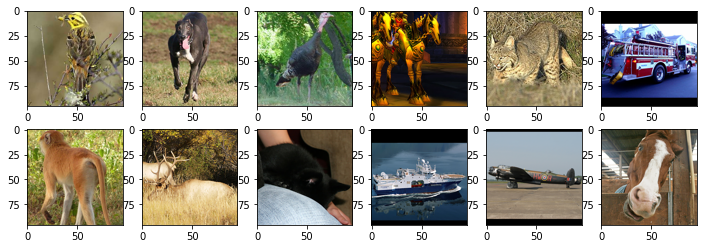

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
  ax.imshow(X_train[i].transpose(1,2,0))
plt.show()

In [12]:
# load STL-10 test data
X_test, y_test = _load_stl10("test")

test images
(8000, 3, 96, 96)
(8000,)


## Test protocol #1 PCA features

In [0]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=config['model']['out_dim'])

X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

print("PCA features")
print(X_train_pca.shape)
print(X_test_pca.shape)

In [0]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))

In [0]:
linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

## clean up resources
del X_train_pca
del X_test_pca

## Protocol #2 Logisitc Regression

In [0]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, 'resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [0]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

In [0]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [0]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

In [0]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

In [0]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature